# Dynamic QSP reporting with Julia and Jupiter

Heta code

```heta
include BIOMD0000000448_url.xml type sbml

// model updates
insulin @Const = 10; // nM

// observables
block {output: true} begin
  measuredIRp;
  measuredIRint;
  measuredIRS1p;
  measuredIRS1307;
  measuredPKB308p;
  measuredPKB473p;
  measuredAS160p;
  measuredmTORC1a;
  measuredS6Kp;
  glucoseuptake;
  measuredmTORC2a;
  measuredS6p;

  GLUT4;
  GLUT4m;
end

// IR (insuline dependent)
IR_total @Const = 100; // IR reduce 55%
GLUT4_total @Const = 100;// GLUT4 reduce 50%
diabetes @Const = 1; // diabetes 15%
//
IR .= IR_total * 99.87/100; // 99.87
IRp .= 0;
IRins .= 0;
IRip .= IR_total * 0.02/100;      // 0.02
IRi .= IR_total * 0.11/100;       // 0.11
//
GLUT4 .= GLUT4_total * 73.48/100;   // 73.48
GLUT4m .= GLUT4_total * 26.52/100;  // 26.52
```

## Preparations

In [8]:
using HetaSimulator, StatsPlots

## Loading platform

In [10]:
p = load_platform("..", rm_out = true)

Running compilation with declaration file "Y:\PLATFORMS\insulin-signaling-t2d\platform.json"...
[info] Builder initialized in directory "Y:\PLATFORMS\insulin-signaling-t2d".
[info] Platform id: "template"
[info] Compilation of module "src/index.heta" of type "heta"...
[info] Reading module of type "heta" from file "Y:\PLATFORMS\insulin-signaling-t2d\src\index.heta"...
[info] Reading module of type "sbml" from file "Y:\PLATFORMS\insulin-signaling-t2d\src\BIOMD0000000448_url.xml"...
[info] Setting references in elements, total length 170
[info] Checking for circular references in Records.
[warn] Units checking skipped. To turn it on set "unitsCheck: true" in declaration.
[info] Checking unit's terms.
[warn] "Julia only" mode
[info] Exporting to "Y:\PLATFORMS\insulin-signaling-t2d\_julia" of format "Julia"...
Compilation OK!
Loading platform... OK!


Platform with 1 model(s), 0 scenario(s), 0 measurement(s)
   Models: nameless
   Scenarios: 


In [11]:
m = models(p)[:nameless]

Model contains 4 constant(s), 128 record(s), 0 switcher(s).
   Constants: diabetes, insulin, IR_total, GLUT4_total
   Records: cellvolume, IR, IRp, IRins, IRip, IRi, IRS1, IRS1p, IRS1p307, IRS1307, ...
   Switchers (events): 


## Default simulation

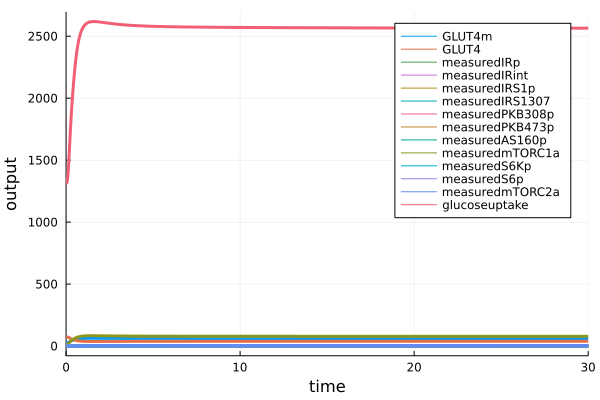

In [12]:
Scenario(m, (0.,30.)) |> sim |> plot

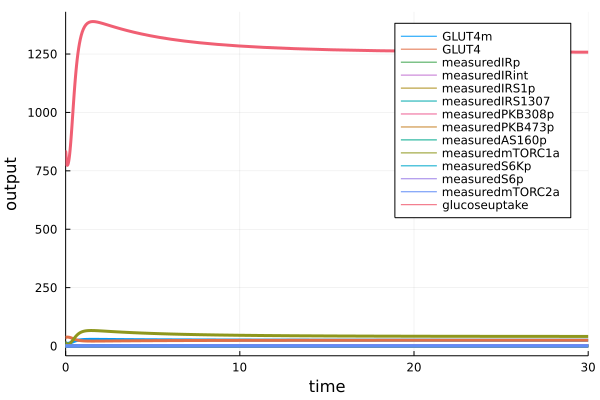

In [13]:
Scenario(m, (0.,30.), parameters = [:IR_total=>55., :GLUT4_total=>50, :diabetes=>0.15]) |> sim |> plot

## Simulation scenarios

In [15]:
scn_csv = read_scenarios("../julia/scenarios.csv")
add_scenarios!(p, scn_csv)
p

Platform with 1 model(s), 2 scenario(s), 0 measurement(s)
   Models: nameless
   Scenarios: base, ir


## Advanced visualization

In [40]:
results_df = p |> sim |> DataFrame
first(results_df, 10)

,t,GLUT4m,GLUT4,measuredIRp,measuredIRint,measuredIRS1p,measuredIRS1307
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,26.52,73.48,0.104044,0.13,0.123621,0.999125
2,7.67533e-6,26.5201,73.4799,0.104187,0.13,0.123622,0.999125
3,2.29935e-5,26.5202,73.4798,0.104468,0.129999,0.123624,0.999125
4,4.29785e-5,26.5203,73.4797,0.104822,0.129998,0.123626,0.999126
5,7.10819e-5,26.5205,73.4795,0.105298,0.129996,0.123629,0.999126
6,0.000109594,26.5207,73.4793,0.105913,0.129994,0.123634,0.999127
7,0.000163956,26.521,73.479,0.106712,0.129992,0.12364,0.999128
8,0.000227241,26.5213,73.4787,0.10755,0.129989,0.123647,0.999129
9,0.000285679,26.5215,73.4785,0.108245,0.129987,0.123653,0.99913


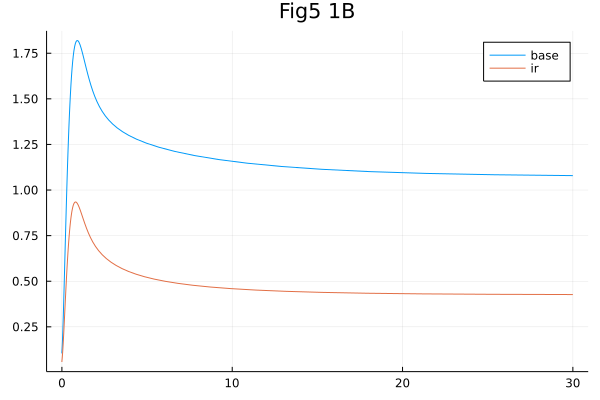

In [17]:
@df results_df plot(:t, :measuredIRp, group = :scenario, title = "Fig5 1B")

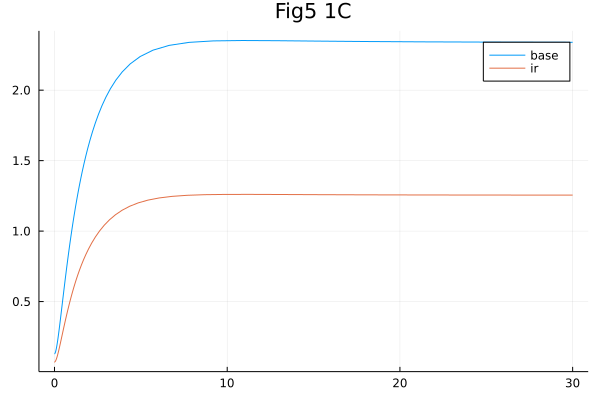

In [18]:
@df results_df plot(:t, :measuredIRint, group = :scenario, title = "Fig5 1C")

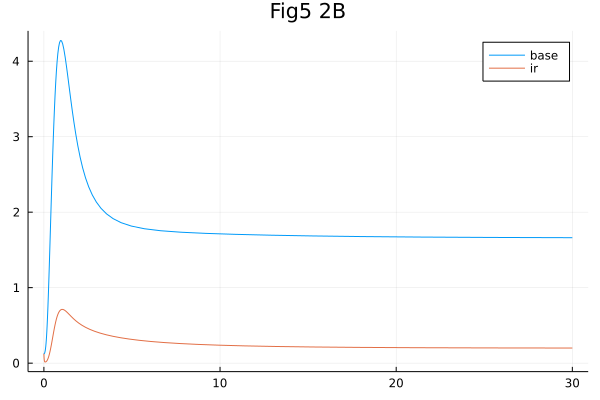

In [19]:
@df results_df plot(:t, :measuredIRS1p, group = :scenario, title = "Fig5 2B")

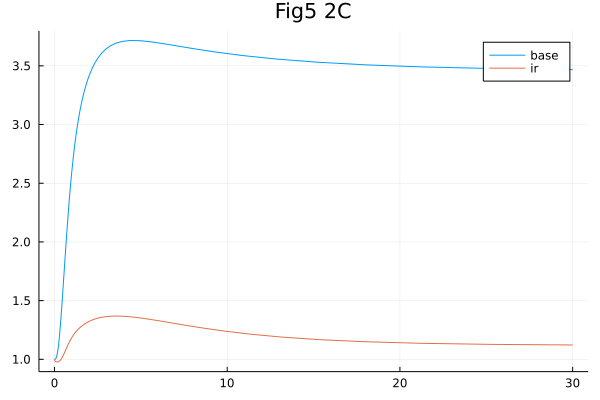

In [20]:
@df results_df plot(:t, :measuredIRS1307, group = :scenario, title = "Fig5 2C")

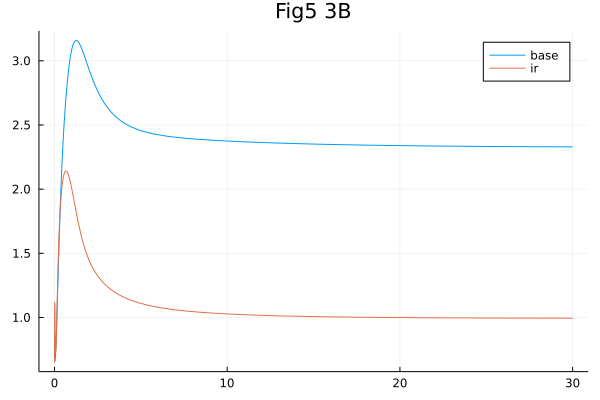

In [21]:
@df results_df plot(:t, :measuredPKB308p, group = :scenario, title = "Fig5 3B")

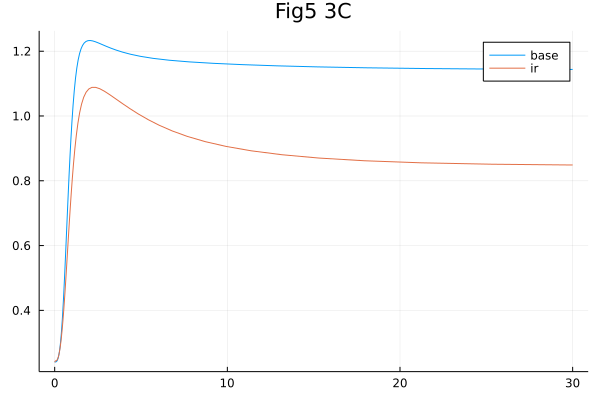

In [22]:
@df results_df plot(:t, :measuredPKB473p, group = :scenario, title = "Fig5 3C")

## Titration-like simulations

In [31]:
scn_titr_csv = read_scenarios("../julia/titration.csv")
add_scenarios!(p, scn_titr_csv)

In [34]:
results_titr = sim(p, saveat=[10.]);
results_titr_df = DataFrame(results_titr, add_parameters=true);
results_titr_subset = subset(results_titr_df, Symbol("tags.titr")=>x->x.===true);

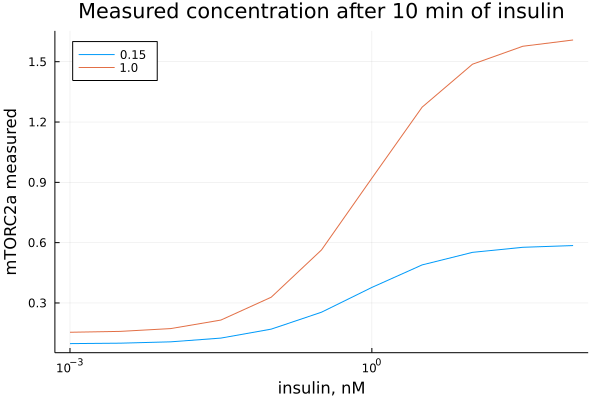

In [52]:
@df results_titr_subset plot(
    :insulin, :measuredmTORC2a,
    title = "Measured concentration after 10 min of insulin",
    xlabel="insulin, nM", ylabel="mTORC2a measured",
    group=:diabetes,
    xscale = :log10,
    legend = :topleft
)

## Multiple simulations